# Example: Hedging

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import scipy
import seaborn
from tqdm import tqdm
import yfinance as yf
from scipy.stats import norm

Define the Utility function from prospect theory

In [2]:
def U(x,a=0.88,b=2.25):
    if x>0:
        return (x**(a))
    if x<=0:
        return b*((-x)**(a))

Depict in some nice plots

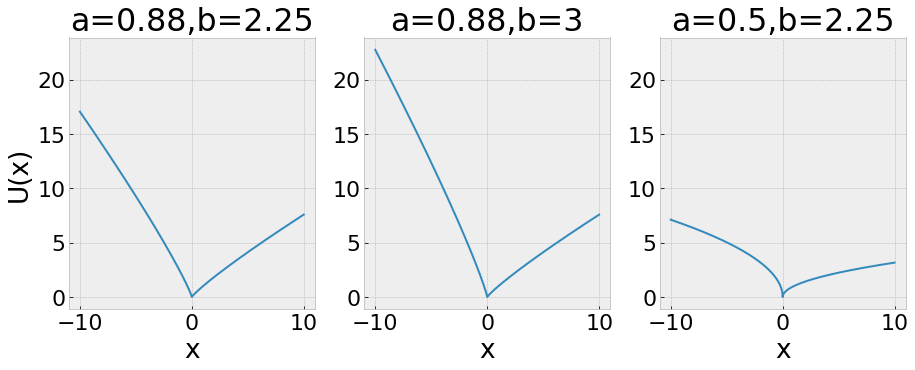

In [3]:
# Plot everything
x_range = np.arange(-10,10,0.01)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2, sharex=ax1,sharey=ax1)
ax3 = fig.add_subplot(1, 3, 3, sharex=ax1,sharey=ax1)

ax1.plot(x_range,[U(x) for x in x_range])
ax1.set_title("a=0.88,b=2.25")
ax1.set_xlabel("x")
ax1.set_ylabel("U(x)")
ax1.grid(True)

ax2.plot(x_range,[U(x,a=0.88,b=3) for x in x_range])
ax2.set_title("a=0.88,b=3")
ax2.set_xlabel("x")
#ax2.set_ylabel("U(x)")
ax2.grid(True)

ax3.plot(x_range,[U(x,a=0.5,b=2.25) for x in x_range])
ax3.set_title("a=0.5,b=2.25")
ax3.set_xlabel("x")
#ax2.set_ylabel("U(x)")
ax3.grid(True)

plt.savefig('s-shape.pdf', format='pdf',bbox_inches='tight')
plt.show()

Interpolation and Depiction of it

In [4]:
def V(x,a=0.88,b=2.25,delta = 0.1):
    if np.abs(x)>delta:
        return U(x,a,b)
    if x <= 0 and x >= -delta:
        return -x * U(-delta,a,b)/delta
    if x >= 0 and x < delta:
        return x * U(delta,a,b)/delta

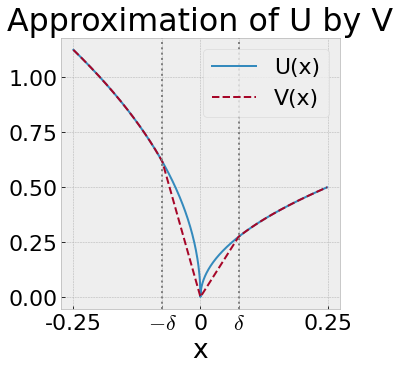

In [5]:
# Plot everything
x_range = np.arange(-0.25,0.25,0.001)
a = 0.5
b = 2.25

delta = 0.075

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(x_range,[U(x,a,b) for x in x_range],label = "U(x)")
ax1.set_title("Approximation of U by V")
ax1.set_xlabel("x")
ax1.grid(True)

ax1.plot(x_range,[V(x,a,b,delta = delta) for x in x_range],label = "V(x)",linestyle = "dashed")
ax1.set_xlabel("x")
ax1.grid(True)

# Add horizontal lines at y = 0.1
ax1.axvline(-delta, color='gray', linestyle="dotted")
ax1.axvline(delta, color='gray', linestyle= "dotted")
ax1.set_xticks([-0.25,-delta,0,delta,0.25])
ax1.set_xticklabels(["-0.25","$-\delta$","0", "$\delta$","0.25"])

plt.legend()
plt.savefig('s-shape_V.pdf', format='pdf',bbox_inches='tight')
plt.show()

Download Stock Prices
and create a Training Period

In [6]:
S_train = yf.download("AAPL", start="2010-01-02", end="2020-02-01")
S_train = S_train.dropna()
S_train = S_train.reset_index()
S_train = S_train[["Date","Close"]]

Returns_train = np.diff(S_train["Close"])/S_train["Close"][:-1]
# A Tensorflow Adaption
Returns_train_tf = tf.reshape(Returns_train,(1,len(Returns_train)))

[*********************100%***********************]  1 of 1 completed


Test Period 1: Feb 2020 - May 2020

In [7]:
S_test1 = yf.download("AAPL", start="2020-02-01", end="2020-05-01")
S_test1 = S_test1.dropna()
S_test1 = S_test1.reset_index()
S_test1 = S_test1[["Date","Close"]]

Returns_test1= np.diff(S_test1["Close"])/S_test1["Close"][:-1]
# A Tensorflow Adaption
Returns_test1_tf = tf.reshape(Returns_test1,(1,len(Returns_test1)))

[*********************100%***********************]  1 of 1 completed


Test Period 2: May 2020 - August 2020

In [8]:
S_test2 = yf.download("AAPL", start="2020-05-01", end="2020-08-01")
S_test2 = S_test2.dropna()
S_test2 = S_test2.reset_index()
S_test2 = S_test2[["Date","Close"]]

Returns_test2= np.diff(S_test2["Close"])/S_test2["Close"][:-1]
# A Tensorflow Adaption
Returns_test2_tf = tf.reshape(Returns_test2,(1,len(Returns_test2)))

[*********************100%***********************]  1 of 1 completed


Depict Training and Testing Periods

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


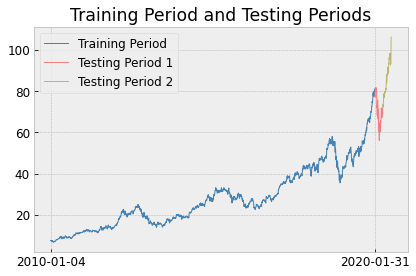

In [9]:
matplotlib.rcParams.update({'font.size': 12})
plt.plot(range(len(S_train)),
         S_train["Close"],label="Training Period",color="steelblue", linewidth=1)
plt.plot(range(len(S_train),len(S_train)+len(S_test1)),
         S_test1["Close"],label="Testing Period 1",color="lightcoral", linewidth=1)
plt.plot(range(len(S_train)+len(S_test1),len(S_train)+len(S_test1)+len(S_test2)),
         S_test2["Close"],label="Testing Period 2",color="darkkhaki", linewidth=1)
plt.title("Training Period and Testing Periods")
xtick_numbers1 = [0,len(S_train)] #,len(S_train)+len(S_test1),len(S_train)+len(S_test1)+len(S_test2)]
plt.xticks(xtick_numbers1, [S_train["Date"].dt.date.iloc[xtick_numbers1[0]],S_train["Date"].dt.date.iloc[xtick_numbers1[1]-1]] )#,S_test1["Date"].dt.date.iloc[0],S_test2["Date"].dt.date.iloc[0]])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('portfolio_train_test_split.eps', format='eps')
plt.show()

Define a Function to sample the next state according to

$$
\Omega^t \ni \omega^t \mapsto \widehat{\mathbb{P}}_t\left(\omega^t\right) (d x):= \sum_{s=t}^{N-1}\pi_s(\omega^t) \cdot \delta_{\mathscr{R}_{s+1}}(d x)\in \mathcal{M}_1(\Omega_{loc}),
$$
with
$$
\Omega^t \ni \omega^t \mapsto \pi_s(\omega^t):= \left(\frac{\exp(-\beta\operatorname{dist}_s(\omega^t)^2)}{\sum_{\ell=t}^{N-1}\exp(-\beta\operatorname{dist}_{\ell}(\omega^t)^2)}\right),
$$

In [10]:
def sample_omega(omega,t,N_MC,beta = 5000000):
    Returns_lagged = tf.concat([Returns_train_tf[:,i:(-t+i)] for i in range(t)],axis = 0) #(t,N_Returns)
    Returns_lagged = tf.cast(tf.transpose(Returns_lagged),tf.float32)[:-1,:] # Do not allow for the last return to be considered (as it should be possible to predict it)
    dist = np.exp(-beta*tf.reduce_sum((Returns_lagged-omega)**2,axis=1))
    probs = np.array(dist)/tf.reduce_sum(dist)
    #print(pd.DataFrame(probs).describe())
    p_hat = tfp.distributions.Categorical(probs=dist)
    closest_returns_indices = np.array(p_hat.sample(N_MC)+t,dtype = int)      #(Batch)
    return tf.cast(tf.reshape(Returns_train[closest_returns_indices],(N_MC,1)),tf.float32)

Define the payoff function
\begin{aligned}
\Omega \times A \ni (\omega, a) \mapsto \Psi(\omega,a):= -V\Bigg(d+\sum_{j=0}^{T-1}   &\Delta_j (S_{j+1}-S_j)-\Phi(S_T)\Bigg),
\end{aligned}.
for
$a = ((d_0,\Delta_0),(d_1,\Delta_1), \dots, (d_{T-1},\Delta_{T-1}))\in[-C,C]^{2T}$ and $\omega = (\omega_1,\dots,\omega_{T}) \in [-C,C]^T$

where $S_t = S_0 \cdot (1+\omega_1) \cdot \dots \cdot (1+\omega_t)$


In [11]:
# Tensorflow adaption of U
def U_tf(x, a=0.88, b=2.25):
    x_inp = tf.cast(x, tf.float32)
    pos = tf.pow(tf.maximum(x_inp,0), a)
    neg = b * tf.pow(tf.maximum(-x_inp, 0), a)  # Here Maximum necessary yo have gradients
    return pos + neg

def Psi(input_dict,S_0 = 1):
    omega, a = input_dict["omega"], input_dict["a"] #(N_MC,T) for omega and #(N_MC,T+1)  for a
    S = S_0*tf.math.cumprod(omega+1,axis =1)
    cash = a[:,0]
    profit = tf.reduce_sum((S[:,1:]-S[:,:-1])*a[:,2:],axis=1)+a[:,1]*(S[:,0]-S_0)
    payoff = tf.nn.relu(S[:,-1]-S_0) # At the money call option
    return -U_tf(cash+profit-payoff)

def Psi_quadratic(input_dict,S_0 = 1):
    omega, a = input_dict["omega"], input_dict["a"] #(N_MC,T) for omega and #(N_MC,T+1)  for a
    S = S_0*tf.math.cumprod(omega+1,axis =1)
    cash = a[:,0]
    profit = tf.reduce_sum((S[:,1:]-S[:,:-1])*a[:,2:],axis=1)+a[:,1]*(S[:,0]-S_0)
    payoff = tf.nn.relu(S[:,-1]-S_0) # At the money call option
    return -(cash+profit-payoff)**2

Function to create neural network

In [12]:
def build_model_a(Input_Dim,T=5,depth =5,nr_neurons =32):
    """
    Function that creates the neural network for a
    """
    #Input Layer
    omega = keras.Input(shape=(Input_Dim,),name = "omega")
    a = keras.Input(shape=(1+Input_Dim,),name = "a")

    in1 = tf.keras.layers.Flatten()(omega)
    in2 = tf.keras.layers.Flatten()(a)
    # concatenate
    v = layers.concatenate([in1,in2])
    # Batch Normalization applied to the input
    #v = layers.BatchNormalization()(v)

    # Create the NN
    v = layers.Dense(nr_neurons,activation = "relu")(v) #,kernel_regularizer=tf.keras.regularizers.L1(0.01))(v)

    for i in range(depth):
        #v = layers.BatchNormalization()(v)
        v= layers.Dense(nr_neurons,activation = "relu")(v) #,kernel_regularizer=tf.keras.regularizers.L1(0.01))(v)
    # Output Layers
    #value_out = layers.Dense(1,activation = "tanh")(v)
    value_out = layers.Dense(1,activation = "sigmoid")(v)
    model = keras.Model(inputs=[omega,a],outputs = [value_out])
    return model

In [13]:
def build_model_psi(Input_Dim,T=5,depth =5,nr_neurons =32):
    """
    Function that creates the neural network for the value function V
    """
    #Input Layer
    omega = keras.Input(shape=(Input_Dim,),name = "omega")
    a = keras.Input(shape=(1+Input_Dim,),name = "a")

    in1 = tf.keras.layers.Flatten()(omega)
    in2 = tf.keras.layers.Flatten()(a)
    # concatenate
    v = layers.concatenate([in1,in2])
    # Batch Normalization applied to the input
    #v = layers.BatchNormalization()(v)

    # Create the NN
    v = layers.Dense(nr_neurons,activation = "relu")(v) #,kernel_regularizer=tf.keras.regularizers.L1(0.01))(v)
    # Create deep layers
    for i in range(depth):
        #v = layers.BatchNormalization()(v)
        v = layers.Dense(nr_neurons,activation =  "relu")(v) #,kernel_regularizer=tf.keras.regularizers.L1(0.01))(v)
    # Output Layers
    value_out = layers.Dense(1)(v)
    model = keras.Model(inputs=[omega,a],outputs = [value_out])
    return model

Assign the neural networks for $a$ and $\Psi$

In [14]:
# Create Models
def create_models(T=5,learning_rate = 0.001):
    a_tilde = []
    Psi_tilde = []
    optimizer_a = []
    optimizer_Psi = []

    # time 0
    a_tilde.append(tf.Variable([0.,0.5],trainable=True,dtype = "float32")) # inititial cash d_0 and Delta_0
    Psi_tilde.append(tf.Variable([1,],trainable=True,dtype = "float32")) # just a placeholder. actually not needed
    # Create optimizers
    optimizer_a.append(tf.keras.optimizers.Adam(learning_rate = learning_rate) )
    optimizer_Psi.append(tf.keras.optimizers.Adam(learning_rate = learning_rate) ) # just a placeholder. actually not needed

    # Times 1 to T-1
    for t in range(1,T):
        a_tilde.append(build_model_a(t,T=T))
        Psi_tilde.append(build_model_psi(t,T=T))
         # Create optimizers
        optimizer_a.append(tf.keras.optimizers.Adam(learning_rate = learning_rate) )
        optimizer_Psi.append(tf.keras.optimizers.Adam(learning_rate = learning_rate) )
    # Time T
    Psi_tilde.append(Psi)
    optimizer_Psi.append(tf.keras.optimizers.Adam(learning_rate = learning_rate) )

    # Define the optimizers for a and Psi respectively
    return a_tilde, Psi_tilde, optimizer_a, optimizer_Psi

### Define the important functions

Function to sample some state until time t

$$
\Omega_{loc} = [-C,C]
$$

States correspond to returns $\frac{S_t-S_{t-1}}{S_{t-1}}$

In [15]:
def sample_state(t, # time
                 C=5):
    Returns_lagged = tf.concat([Returns_train_tf[:,i:(-t+i)] for i in range(t)],axis = 0) #(t,N_Returns)
    Returns_lagged = tf.cast(Returns_lagged,tf.float32) # Do not allow for the last return to be considered (as it should be possible to predict it)
    index = np.random.choice(Returns_lagged.shape[1],1)[0]
    return tf.cast(tf.reshape(Returns_lagged[:,index],(1,t)),tf.float32) #(1,t)

Function to sample some time t action

We have
$$
A:= [-D,D]^2.
$$

In [16]:
def sample_action(t,D=1):
    vals = tf.random.uniform([1+t], minval = -D,maxval=D)
    return tf.reshape(tf.cast(vals,tf.float32),(1,1+t))

Function to maximize the expectation w.r.t. the neural network a_t

# Description of the Algorithm

For $t = T-1, \cdots , 1$ :


For $j = 1,\dots, N_{iterations}$:

Sample $(\omega_1,\dots,\omega_t)=\omega^t$

Sample $(a_0,\dots,a_{t-1})=a^t$

For $k = 1,\dots, N_{measures}$:

Sample next states
$w^{t+1, (k),(i)} \sim \mathbb{P}_k \in \mathcal{P}_t(\omega^t)$ for $i= 1,\dots,N_{MC}$

<!-- Compute $\tilde{J}_t(\omega,a^t, \tilde{a}) = \min_k \frac{1}{N}\sum_{i=1} \tilde{\Psi}_{t+1}((\omega^t,a^t, \tilde{a}))$
Maximize w.r.t. $\widetilde{a}$:

$\widetilde{a}_t(\omega^t,a^t)=argmax_{\widetilde{a}} \tilde{J}_t(\omega,a^t, \tilde{a})$

Approximate

$\tilde{\Psi}_t(\omega^t, a^t):= \tilde{J}_t(\omega,a^t, \widetilde{a}_t(\omega^t,a^t))$ -->

The optimization step is:

1.)

Maximize
$$
\min_k \frac{1}{N_{MC}}\sum_{i=1}^{N_{MC}} \tilde{\Psi}_{t+1}\left((\omega^t, w^{t+1, (k),(i)}),~\left(a^t, \widetilde{a}_t(\omega^t,a^t)\right)\right) \approx \sup_{\widetilde{a} \in A}\inf_{ P \in \mathcal{P}_t(\omega^t)} E_P \left[\Psi_{t+1}\left(\omega^t \otimes_t \cdot, (a^{t},\widetilde{a})\right)\right]= \Psi_t(\omega^t,a^t)
$$
 w.r.t. parameters of $\tilde{a}_t$:

2.)

Minimize
$$
\left(\tilde{\Psi}_t(\omega^t, a^t)- \min_k \frac{1}{N_{MC}}\sum_{i=1}^{N_{MC}} \tilde{\Psi}_{t+1}\left((\omega^t, w^{t+1, (k),(i)}),~\left(a^t, \widetilde{a}_t(\omega^t,a^t)\right)\right)  \right)^2
$$
 w.r.t. parameters of $\tilde{\Psi}_t$:

Finally, we set:
$$
\Omega^t \ni \omega^t =(\omega_1,\dots,\omega_{t}) \mapsto a_t^*(\omega^t):= \widetilde{a}_t^*\left(\omega^t,~\left(a_0^*,\dots,a_{t-1}^*(\omega_1,\dots,\omega_{t-1}\right)\right) \in A.
$$

### Implementation of the respective Functions

Function "max_a" to maximize the minimal expectation
$$
\max_{\widetilde{a}_t} \min_k \frac{1}{N_{MC}}\sum_{i=1}^{N_{MC}} \tilde{\Psi}_{t+1}\left((\omega^t, w^{t+1, (k),(i)}),~\left(a^t, \widetilde{a}_t(\omega^t,a^t)\right)\right)
$$

In [17]:
def max_a(Psi_tilde,a_tilde,N_measures,omega, a,t,optimizer_a,N_MC =128,epsilon=0,T=5):
    with tf.GradientTape() as tape:
        loss_a = -tf.reduce_mean(min_exp(Psi_tilde,a_tilde,N_measures,omega,a,t,N_MC,training_a = True,
                                         training_Psi = False,epsilon =epsilon,T=T))
    if t>0:
        gradient_a = tape.gradient(loss_a,a_tilde[t].trainable_variables)
        optimizer_a[t].apply_gradients(zip(gradient_a, a_tilde[t].trainable_variables))
    if t == 0:
        gradient_a = tape.gradient(loss_a,[a_tilde[t]])
        optimizer_a[t].apply_gradients(zip(gradient_a, [a_tilde[t]]))
    return -loss_a, a_tilde, optimizer_a

Function "min_exp" to Compute the Monte Carlo Expectation (of the minimal measure)
$$
\min_k \frac{1}{N_{MC}}\sum_{i=1}^{N_{MC}} \tilde{\Psi}_{t+1}\left((\omega^t, w^{t+1, (k),(i)}),~\left(a^t, \widetilde{a}_t(\omega^t,a^t)\right)\right)
$$

In [18]:
def min_exp(Psi_tilde,a_tilde,N_measures,omega,a,t,N_MC =128,training_a = False,training_Psi = False,epsilon=0,T=5):
    # Compute for each of the measures the Monte Carlo Expectation:
    if t >0:
        expectations = []
        for p in range(N_measures):
            # omega has Dimension t
            scale = tf.random.uniform((N_MC,1),minval=-epsilon,maxval=epsilon)
            noise = tf.random.normal((N_MC,1),stddev=scale)
            next_omega =  sample_omega(omega,t,N_MC) + noise# size = (N_MC,1)  np.random.exponential(scale=scale, size = (N_MC,1))
            old_omega = tf.repeat(omega,N_MC,axis = 0) # Dimension (N_MC,t)
            omega_input = tf.concat([old_omega,next_omega],axis = 1)  # Dimension (N_MC,t+1)
            a_input = tf.concat([a,a_tilde[t]({"omega":omega,"a":a},training = training_a)],axis =1 ) #(1,t+1)
            a_input = tf.repeat(a_input,N_MC,axis = 0) # Dimension (N_MC,t+1)
            expectations.append(tf.reduce_mean(Psi_tilde[t+1]({"omega":omega_input,"a":a_input})))  # Dimension (N_MC)

    if t == 0:
        expectations = []
        for p in range(N_measures):
            # omega has Dimension t
            scale = tf.random.uniform([1],minval=-epsilon,maxval=epsilon)
            noise = tf.random.normal([1],stddev=scale)
            next_omega = tf.cast(tf.reshape(Returns_train[np.random.choice(Returns_train_tf.shape[1],N_MC)],(N_MC,1)),tf.float32)
            omega_input = next_omega  + noise # Dimension (N_MC,t+1)

            a_input = tf.reshape(tf.repeat(a_tilde[t],N_MC),(N_MC,2)) # Dimension (N_MC,1)
            #a_input = tf.repeat(tf.expand_dims(a_input,axis =1),N_MC,axis = 1) # Dimension (B,N_MC,t+1)
            expectations.append(tf.reduce_mean(Psi_tilde[t+1]({"omega":omega_input,
                                                        "a":a_input},training = training_Psi)))

    return tf.reduce_min(expectations,axis = 0)

Function to minimize the error
$$
\left(\tilde{\Psi}_t(\omega^t, a^t)- \min_k \frac{1}{N_{MC}}\sum_{i=1}^{N_{MC}} \tilde{\Psi}_{t+1}\left((\omega^t, w^{t+1, (k),(i)}),~\left(a^t, \widetilde{a}_t(\omega^t,a^t)\right)\right)  \right)^2
$$

In [19]:
def approx_psi(Psi_tilde,a_tilde,N_measures,omega,a,t,optimizer_Psi,N_MC =128,epsilon=0,T=5):
    with tf.GradientTape() as tape:
        loss_psi = tf.reduce_mean((Psi_tilde[t]({"omega":omega,"a":a},
                                                training = True)-min_exp(Psi_tilde,a_tilde,N_measures,
                                                                           omega,a,t,N_MC,epsilon=epsilon,T=T))**2)
    gradient_psi = tape.gradient(loss_psi,Psi_tilde[t].trainable_variables)
    optimizer_Psi[t].apply_gradients(zip(gradient_psi, Psi_tilde[t].trainable_variables))
    return loss_psi, Psi_tilde, optimizer_Psi


# The training algorithm

In [20]:
def train_networks(T= 5,
                   inner_psi = 5000,
                   inner_a = 5000,
                   N_MC = 4096,
                   N_measures =1,
                  epsilon = 0):
    # Assign models and optimizers
    a_tilde, Psi_tilde, optimizer_a, optimizer_Psi = create_models(T)

    print("Start Backwards Iterations")
    for t in range(T)[::-1]: # Backwards Iteration
        #for j in range(N_iterations):
        psi_errors = []
        a_values = []


        print("#########\n# t = {} #\n#########\n".format(t))

        # Maximization w.r.t. a
        for k in range(inner_a):
            if t>0:
                omega_t = sample_state(t)  #(1,t))
                a_t = sample_action(t) #(1,t+1))
            if t== 0:
                a_t = 0.
                omega_t = 0.
              #(1,2*T*t))
            a_value, a_tilde, optimizer_a = max_a(Psi_tilde,a_tilde,N_measures,omega_t,a_t,t,
                                                  optimizer_a,N_MC,epsilon,T)
            a_values.append(a_value)
            if not(k % 25) and k >0:
                print("a: {}".format(np.mean(a_values[-25:])))

        # Minimization of Psi
        if t >0:
            for k in range(inner_psi):
                omega_t = sample_state(t)
                a_t = sample_action(t)
                psi_error, Psi_tilde, optimizer_Psi = approx_psi(Psi_tilde,a_tilde,N_measures,omega_t,a_t,t,
                                                                 optimizer_Psi,N_MC,epsilon,T) # Fit Psi_t and J_t
                psi_errors.append(psi_error)
                if not(k % 25) and k >0:
                    print("Psi: {}".format(np.mean(psi_errors[-25:])))
    return a_tilde, Psi_tilde

# Training

Number of periods

In [21]:
T = 5

Train the non-robust version

In [22]:
a_tilde, Psi_tilde = train_networks(T=T)

Start Backwards Iterations
#########
# t = 4 #
#########

a: -1.1218141317367554
a: -0.8351722955703735
a: -0.9180766344070435
a: -0.7802271246910095
a: -1.0185589790344238
a: -0.8200903534889221
a: -0.7862545251846313
a: -0.7672628164291382
a: -0.8501625061035156
a: -0.975075900554657
a: -0.7683898210525513
a: -0.7140491604804993
a: -0.8109286427497864
a: -0.9315700531005859
a: -0.8255606889724731
a: -0.6814010739326477
a: -0.9730117917060852
a: -0.9973701238632202
a: -1.011327862739563
a: -0.8762812614440918
a: -0.9946632981300354
a: -0.8888993859291077
a: -0.5731139779090881
a: -0.9958920478820801
a: -1.1171317100524902
a: -0.8697378039360046
a: -0.8499485850334167
a: -0.7250069379806519
a: -0.7927138805389404
a: -0.6785458326339722
a: -0.7689030170440674
a: -0.9364219903945923
a: -0.9169389605522156
a: -1.0418261289596558
a: -1.0913376808166504
a: -1.0432661771774292
a: -0.8029060363769531
a: -0.6470699310302734
a: -0.9196558594703674
a: -0.8641787767410278
a: -1.0190500020980835
a

Psi: 0.01727624237537384
Psi: 0.008998628705739975
Psi: 0.008748505264520645
Psi: 0.018638940528035164
Psi: 0.006275459658354521
Psi: 0.006222729571163654
Psi: 0.0036481651477515697
Psi: 0.005741202738136053
Psi: 0.002669371897354722
Psi: 0.0036710305139422417
Psi: 0.009890604764223099
Psi: 0.009936202317476273
Psi: 0.010364042595028877
Psi: 0.011161086149513721
Psi: 0.004072258714586496
Psi: 0.002467727055773139
Psi: 0.004428916610777378
Psi: 0.002529073040932417
Psi: 0.008365314453840256
Psi: 0.008791068568825722
Psi: 0.0048754229210317135
Psi: 0.006002380046993494
Psi: 0.011619588360190392
Psi: 0.005498984828591347
Psi: 0.00868897046893835
Psi: 0.005899620242416859
Psi: 0.004195906687527895
Psi: 0.004528948105871677
Psi: 0.004627682268619537
Psi: 0.007321229670196772
Psi: 0.005845385137945414
Psi: 0.006794098764657974
Psi: 0.005113763269037008
Psi: 0.004688606131821871
Psi: 0.009132737293839455
Psi: 0.00842592678964138
Psi: 0.005652261897921562
Psi: 0.0037911776453256607
Psi: 0.0030

Psi: 0.006061488762497902
Psi: 0.002983290934935212
Psi: 0.002470354549586773
Psi: 0.003319482784718275
Psi: 0.0059121171943843365
Psi: 0.004767180420458317
Psi: 0.003140188055112958
Psi: 0.002711169421672821
Psi: 0.005302744917571545
Psi: 0.0012391945347189903
Psi: 0.0024275770410895348
Psi: 0.0028905062936246395
Psi: 0.0031860924791544676
Psi: 0.0037868476938456297
Psi: 0.002839831169694662
Psi: 0.0019364821491762996
Psi: 0.0016567348502576351
Psi: 0.0035019838251173496
Psi: 0.002096874639391899
Psi: 0.002653702162206173
Psi: 0.00810866430401802
Psi: 0.0034607681445777416
Psi: 0.0019428660161793232
Psi: 0.0017923248233273625
Psi: 0.004199874587357044
Psi: 0.003576756687834859
Psi: 0.01668623648583889
Psi: 0.010355187579989433
Psi: 0.008506215177476406
Psi: 0.008807175792753696
Psi: 0.0037540250923484564
Psi: 0.0026063802652060986
Psi: 0.0027596219442784786
Psi: 0.0014482967089861631
Psi: 0.0017506247386336327
Psi: 0.00452011963352561
Psi: 0.002436537528410554
Psi: 0.00175106758251786

Psi: 0.005484866444021463
Psi: 0.004983463324606419
Psi: 0.004420798271894455
Psi: 0.0044230748899281025
Psi: 0.004101351834833622
Psi: 0.005539989564567804
Psi: 0.00466885045170784
Psi: 0.0017275155987590551
Psi: 0.004137182142585516
Psi: 0.004085418302565813
Psi: 0.0032933226320892572
Psi: 0.005623911041766405
Psi: 0.006813384126871824
Psi: 0.003947763238102198
Psi: 0.002945820102468133
Psi: 0.001906371209770441
Psi: 0.0029277002904564142
Psi: 0.003779404563829303
Psi: 0.003298237221315503
Psi: 0.0021997373551130295
Psi: 0.005223109852522612
Psi: 0.002249150536954403
Psi: 0.003014629241079092
Psi: 0.004679555539041758
Psi: 0.002404486294835806
Psi: 0.0034976599272340536
Psi: 0.002742963843047619
Psi: 0.008037921972572803
Psi: 0.0017988081090152264
Psi: 0.0011597777483984828
Psi: 0.000926556414924562
Psi: 0.002767738653346896
Psi: 0.002369920490309596
Psi: 0.002252696081995964
Psi: 0.002093748189508915
Psi: 0.0024232366122305393
Psi: 0.007317373063415289
Psi: 0.002097661606967449
Psi:

a: -0.8695130348205566
a: -0.9691867828369141
a: -0.7257237434387207
a: -0.8058501482009888
a: -0.7059430480003357
a: -0.8281904458999634
a: -0.7558944225311279
a: -0.6391716599464417
a: -0.9881523251533508
a: -0.6995081901550293
a: -0.6601396203041077
a: -0.7709519863128662
a: -0.921500563621521
a: -0.8898077607154846
a: -0.9440743327140808
a: -0.6424112915992737
a: -0.981182336807251
a: -0.7998760342597961
a: -0.9131733775138855
a: -0.7752883434295654
a: -0.6255007386207581
a: -0.755577802658081
a: -0.8211209774017334
a: -0.7668968439102173
a: -0.7338035106658936
a: -0.7848911285400391
a: -0.7490398287773132
a: -1.0067061185836792
a: -0.9305517673492432
a: -0.8508981466293335
a: -0.7983022332191467
a: -0.9365752339363098
a: -0.8638654947280884
a: -0.7279883623123169
a: -0.8018864989280701
a: -0.7302875518798828
a: -0.8096261024475098
a: -0.7920495867729187
a: -0.8616428971290588
a: -0.7548109292984009
a: -0.6137657165527344
a: -0.9805009961128235
a: -0.7592178583145142
a: -0.68787962

a: -0.07803190499544144
a: -0.07802927494049072
a: -0.07803627103567123
a: -0.0780339315533638
a: -0.07803598046302795
a: -0.0780353993177414
a: -0.07803594321012497
a: -0.07803935557603836
a: -0.07803650200366974
a: -0.07803579419851303
a: -0.07803382724523544
a: -0.0780298262834549
a: -0.07803305238485336
a: -0.07804084569215775
a: -0.0780310183763504
a: -0.07803883403539658
a: -0.0780361145734787
a: -0.07802741229534149
a: -0.07803723216056824
a: -0.07803766429424286
a: -0.07803425937891006
a: -0.07803089916706085
a: -0.07803289592266083
a: -0.07803536206483841
a: -0.07803370803594589
a: -0.07803083211183548
a: -0.07803747802972794
a: -0.07803237438201904
a: -0.07803548872470856
a: -0.0780373141169548
a: -0.07803115993738174
a: -0.0780385360121727
a: -0.0780370831489563
a: -0.0780368447303772
a: -0.07803629338741302
a: -0.07803667336702347
a: -0.07803414762020111
a: -0.07803075015544891
a: -0.07803434133529663
a: -0.07803759723901749
a: -0.07803705334663391
a: -0.07803568243980408
a

Train the robust version

In [23]:
a_tilde_robust, Psi_tilde_robust = train_networks(T=T,N_measures =5,epsilon = 0.001)

Start Backwards Iterations
#########
# t = 4 #
#########

a: -0.6685128211975098
a: -1.029271125793457
a: -1.0515846014022827
a: -0.964536726474762
a: -0.6432315707206726
a: -1.2260292768478394
a: -0.8642436265945435
a: -0.8232623934745789
a: -0.8994259834289551
a: -1.0831352472305298
a: -0.715782880783081
a: -0.683441162109375
a: -0.9064930081367493
a: -0.6686034202575684
a: -0.8197999000549316
a: -0.6355736255645752
a: -0.9782669544219971
a: -0.7666784524917603
a: -1.0060210227966309
a: -0.7819515466690063
a: -0.9037784337997437
a: -1.018970012664795
a: -0.6930847764015198
a: -0.8374611139297485
a: -0.9323187470436096
a: -1.0335239171981812
a: -0.9622892737388611
a: -0.6749392151832581
a: -1.0000920295715332
a: -0.9346038103103638
a: -0.7583568096160889
a: -0.6093906164169312
a: -0.9238251447677612
a: -0.8146491050720215
a: -0.9588215351104736
a: -0.9222224950790405
a: -0.8636773824691772
a: -0.8707586526870728
a: -0.8692374229431152
a: -0.994732677936554
a: -0.9163045287132263
a: -0

Psi: 0.004849350545555353
Psi: 0.010658401995897293
Psi: 0.006456764880567789
Psi: 0.004777530673891306
Psi: 0.0028579351492226124
Psi: 0.006445491686463356
Psi: 0.006009518634527922
Psi: 0.007164797745645046
Psi: 0.004526740871369839
Psi: 0.0037530423142015934
Psi: 0.005858821328729391
Psi: 0.002182593336328864
Psi: 0.003792066592723131
Psi: 0.0058474475517869
Psi: 0.002763778204098344
Psi: 0.002616618061438203
Psi: 0.00356703600846231
Psi: 0.0036164908669888973
Psi: 0.0053599220700562
Psi: 0.0034950196277350187
Psi: 0.010187244042754173
Psi: 0.005277491640299559
Psi: 0.0022765027824789286
Psi: 0.007389293517917395
Psi: 0.00848336797207594
Psi: 0.00795217975974083
Psi: 0.006677832454442978
Psi: 0.0054145026952028275
Psi: 0.0031309693586081266
Psi: 0.005586251616477966
Psi: 0.0032761492766439915
Psi: 0.011377781629562378
Psi: 0.004108004737645388
Psi: 0.0022696368396282196
Psi: 0.0038344522472471
Psi: 0.008750035427510738
Psi: 0.0040408107452094555
Psi: 0.00286273006349802
Psi: 0.00578

Psi: 0.0033150329254567623
Psi: 0.004587017931044102
Psi: 0.0021311237942427397
Psi: 0.003288824809715152
Psi: 0.0014873917680233717
Psi: 0.0013503801310434937
Psi: 0.0027796649374067783
Psi: 0.00302332011051476
Psi: 0.002454505767673254
Psi: 0.003230644389986992
Psi: 0.005383787676692009
Psi: 0.0041160425171256065
Psi: 0.014130906201899052
Psi: 0.00288405385799706
Psi: 0.0029070975724607706
Psi: 0.004664577078074217
Psi: 0.0037152888253331184
Psi: 0.005229553207755089
Psi: 0.0023342985659837723
Psi: 0.001953332917764783
Psi: 0.002332309726625681
Psi: 0.004739495925605297
Psi: 0.0028322734870016575
Psi: 0.003441134002059698
Psi: 0.0019937206525355577
Psi: 0.002370011294260621
Psi: 0.005212630610913038
Psi: 0.004266826435923576
Psi: 0.004188384860754013
Psi: 0.0034958692267537117
Psi: 0.001992130884900689
Psi: 0.006812177132815123
Psi: 0.004177806433290243
Psi: 0.0016397584695369005
Psi: 0.0019598749931901693
Psi: 0.003727140137925744
Psi: 0.015044396743178368
Psi: 0.007825986482203007


Psi: 0.004354072734713554
Psi: 0.007440162356942892
Psi: 0.008701982907950878
Psi: 0.003342581447213888
Psi: 0.0026130848564207554
Psi: 0.005341588985174894
Psi: 0.0016388189978897572
Psi: 0.0014196857810020447
Psi: 0.0032382127828896046
Psi: 0.0030335283372551203
Psi: 0.0054755969904363155
Psi: 0.005075463559478521
Psi: 0.004217933397740126
Psi: 0.002024127636104822
Psi: 0.0029415544122457504
Psi: 0.0012509174412116408
Psi: 0.0013372147222980857
Psi: 0.001064976560883224
Psi: 0.0030033341608941555
Psi: 0.002535806503146887
Psi: 0.0036262175999581814
Psi: 0.006207330152392387
Psi: 0.004484927281737328
Psi: 0.0018138977466151118
Psi: 0.0012547412188723683
Psi: 0.0021526687778532505
Psi: 0.009513002820312977
Psi: 0.0021008301991969347
Psi: 0.002136220457032323
Psi: 0.00694742938503623
Psi: 0.008158433251082897
Psi: 0.007236667908728123
Psi: 0.00418499018996954
Psi: 0.0021361568942666054
Psi: 0.0024284697137773037
Psi: 0.0016682513523846865
Psi: 0.0038714981637895107
Psi: 0.00394899118691

a: -0.8765213489532471
a: -0.8458006978034973
a: -0.7601706981658936
a: -0.9524803757667542
a: -0.8651071786880493
a: -0.6545429229736328
a: -0.952391505241394
a: -0.943454384803772
a: -0.918250560760498
a: -1.178944706916809
a: -1.0445003509521484
a: -0.8892570734024048
a: -0.8572681546211243
a: -0.6191186308860779
a: -0.6999648809432983
a: -1.1169202327728271
a: -0.802419900894165
a: -0.8264831304550171
a: -0.9850203990936279
a: -0.724677324295044
a: -0.6650044322013855
a: -0.9361054301261902
a: -0.8370833396911621
a: -0.8475759029388428
a: -0.8584815263748169
a: -1.093113660812378
a: -0.784420907497406
a: -0.8387796878814697
a: -0.7995553016662598
a: -1.005711317062378
a: -0.9314175248146057
a: -0.825094997882843
a: -0.7416270971298218
a: -0.8216740489006042
a: -0.8107162714004517
a: -1.0780060291290283
a: -1.0283997058868408
a: -0.8249732255935669
a: -0.9876189231872559
a: -0.7459737658500671
a: -0.7984954118728638
a: -0.7496793270111084
a: -0.8118948340415955
a: -0.757561028003692

a: -0.10491837561130524
a: -0.10491828620433807
a: -0.1049199178814888
a: -0.10491997748613358
a: -0.10491733253002167
a: -0.10491830855607986
a: -0.10492117702960968
a: -0.10491852462291718
a: -0.10492204874753952
a: -0.1049184501171112
a: -0.1049201712012291
a: -0.10492072999477386
a: -0.10492066293954849
a: -0.1049186959862709
a: -0.10492099076509476
a: -0.10491886734962463
a: -0.10492047667503357
a: -0.10491854697465897
a: -0.10492093861103058
a: -0.10491824895143509
a: -0.10492260009050369
a: -0.10491993278265
a: -0.10491857677698135
a: -0.10492444783449173
a: -0.10491949319839478
a: -0.1049204096198082
a: -0.10491872578859329
a: -0.10492010414600372
a: -0.10491779446601868
a: -0.10492201894521713
a: -0.10491932183504105
a: -0.10491872578859329
a: -0.10491777211427689
a: -0.10491745173931122
a: -0.10491755604743958
a: -0.10491738468408585
a: -0.10491728037595749
a: -0.10491745173931122
a: -0.10491987317800522
a: -0.10491660982370377
a: -0.10491819679737091
a: -0.10492002218961716


Define the optimal action

In [24]:
def a(omega,t,a_tilde):
    a_opt = []
    # t = 0:
    a_opt.append(a_tilde[0])
    # times t >0
    for s in range(t):
        omega_input = tf.reshape([omega[i] for i in range(s+1)],(1,s+1))
        a_input = tf.reshape(tf.concat(a_opt,axis = 0),(1,s+2))
        a_opt.append(a_tilde[s+1]({"omega": omega_input,"a": a_input})[0])
    return a_opt[-1]

# Evaluation

Define Price and Delta in the Black-Scholes model

In [25]:
def blackScholes(r, S, K, T, sigma, type="c"):
    "Calculate BS price of call/put"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if type == "c":
        price = S*norm.cdf(d1, 0, 1) - K*np.exp(-r*T)*norm.cdf(d2, 0, 1)
    elif type == "p":
        price = K*np.exp(-r*T)*norm.cdf(-d2, 0, 1) - S*norm.cdf(-d1, 0, 1)
    return price

def delta_calc(r, S, K, T, sigma, type="c"):
    "Calculate delta of an option"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    if type == "c":
        delta_calc = norm.cdf(d1, 0, 1)
    elif type == "p":
        delta_calc = -norm.cdf(-d1, 0, 1)
    return delta_calc


Define a function for the evaluation of the quality of the trained strategy

In [26]:
def evaluate_nn(dataset,a_tilde,a_tilde_robust):
  Returns_lagged_test1 = tf.concat([dataset[:,i:(-T+i)] for i in range(T)],axis = 0) #(t,N_Returns)
  Returns_lagged_test1  = tf.cast(tf.transpose(Returns_lagged_test1),tf.float32)
  vol = 0.22 # Improve if desired

  Rewards = []
  Rewards_quadratic = []
  Rewards_robust = []
  Rewards_robust_quadratic = []
  Rewards_BS = []
  Rewards_BS_quadratic = []

  # Create Omegas from the Data:
  for j in range(Returns_lagged_test1.shape[0]):
      omega = Returns_lagged_test1[j,:]
      input_dict = {"a": tf.reshape(list(a(omega[:0],0,a_tilde).numpy())+[a(omega[:i],i,a_tilde).numpy()[0] for i in range(1,T)],(1,T+1)),
                    "omega": tf.reshape(omega ,(1,T))}
      input_dict_robust = {"a": tf.reshape(list(a(omega[:0],0,a_tilde_robust).numpy())+[a(omega[:i],i,a_tilde_robust).numpy()[0] for i in range(1,T)],(1,T+1)),
                    "omega": tf.reshape(omega ,(1,T))}

      S = np.cumprod(omega+1)
      Cash = blackScholes(r=0, S=1, K=1, T=T/365, sigma =vol, type="c")
      Delta_0 = delta_calc(r=0, S=1, K=1, T=T/365, sigma =vol, type="c")
      a_BS = [Cash,Delta_0] + [delta_calc(r=0, S=S[i-1], K=1, T=(T-i)/365, sigma =vol, type="c") for i in range(1,T)]
      input_dict_BS = {"a": tf.reshape(tf.cast(a_BS,tf.float32),(1,T+1)),
                    "omega": tf.reshape(omega ,(1,T))}

      Rewards += [-Psi(input_dict)[0].numpy()]
      Rewards_robust += [-Psi(input_dict_robust)[0].numpy()]
      Rewards_BS += [-Psi(input_dict_BS)[0].numpy()]
      Rewards_quadratic += [-Psi_quadratic(input_dict)[0].numpy()]
      Rewards_robust_quadratic += [-Psi_quadratic(input_dict_robust)[0].numpy()]
      Rewards_BS_quadratic += [-Psi_quadratic(input_dict_BS)[0].numpy()]

  df_Rewards = pd.DataFrame(Rewards)
  df_Rewards_robust = pd.DataFrame(Rewards_robust)
  df_Rewards_BS = pd.DataFrame(Rewards_BS)
  df_Rewards_quadratic = pd.DataFrame(Rewards_quadratic)
  df_Rewards_robust_quadratic = pd.DataFrame(Rewards_robust_quadratic)
  df_Rewards_BS_quadratic = pd.DataFrame(Rewards_BS_quadratic)

  df_merged = pd.concat([df_Rewards,df_Rewards_robust,df_Rewards_BS,df_Rewards_quadratic,df_Rewards_robust_quadratic,df_Rewards_BS_quadratic],axis = 1)
  df_merged.columns=["Non-Robust, Prospect Utility ","Robust, Prospect Utility ","Black-Scholes, Prospect Utility","Non-Robust, Quadratic Error ","Robust, Quadratic Error ","Black-Scholes, Quadratic Error"]
  return df_merged, Rewards,Rewards_robust, Rewards_BS, Rewards_quadratic, Rewards_robust_quadratic, Rewards_BS_quadratic

# 1) Evaluation on Training Data

In [36]:
df_merged_1, Rewards_1, Rewards_robust_1, Rewards_BS_1,  Rewards_quadratic_1, Rewards_robust_quadratic_1, Rewards_BS_quadratic_1 = evaluate_nn(Returns_train_tf[:,:50],a_tilde,a_tilde_robust)


df_merged_1.round(4).describe()

,"Non-Robust, Prospect Utility","Robust, Prospect Utility","Black-Scholes, Prospect Utility","Non-Robust, Quadratic Error","Robust, Quadratic Error","Black-Scholes, Quadratic Error"
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,0.055273,0.040307,0.029987,0.000562,0.000824,0.000151
std,0.043907,0.023550,0.032464,0.000666,0.001051,0.000289
min,0.000800,0.001000,0.001000,0.000000,0.000000,0.000000
25%,0.021400,0.022600,0.005800,0.000100,0.000100,0.000000
50%,0.040500,0.037300,0.011900,0.000400,0.000500,0.000000
75%,0.081900,0.051900,0.037600,0.000700,0.001100,0.000100
max,0.174400,0.107800,0.121900,0.003000,0.004800,0.001300


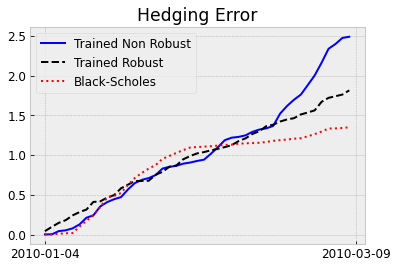

In [37]:
plt.title("Hedging Error")
plt.plot(np.cumsum(Rewards_1),color = "blue",label ="Trained Non Robust")
plt.plot(np.cumsum(Rewards_robust_1),color = "black",label ="Trained Robust",linestyle = "dashed")
plt.plot(np.cumsum(Rewards_BS_1),color = "red",label ="Black-Scholes",linestyle = "dotted")
xtick_numbers_train = [0,len(Rewards_1)] #,len(S_train)+len(S_test1),len(S_train)+len(S_test1)+len(S_test2)]
plt.xticks(xtick_numbers_train, [S_train["Date"].dt.date.iloc[xtick_numbers_train[0]],S_train["Date"].dt.date.iloc[xtick_numbers_train[1]-1]] )#,S_test1["Date"].dt.date.iloc[0],S_test2["Date"].dt.date.iloc[0]])
plt.legend()
plt.grid(True)
plt.legend()


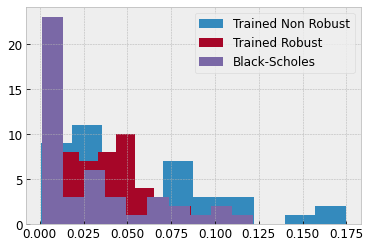

In [38]:
plt.hist(Rewards_1,label ="Trained Non Robust")
plt.hist(Rewards_robust_1,label ="Trained Robust")
plt.hist(Rewards_BS_1,label ="Black-Scholes")

plt.legend()
plt.show()

# 2) Evaluation in Testing Period 1

In [39]:
df_merged_2, Rewards_2, Rewards_robust_2, Rewards_BS_2,  Rewards_quadratic_2, Rewards_robust_quadratic_2, Rewards_BS_quadratic_2 = evaluate_nn(Returns_test1_tf,a_tilde,a_tilde_robust)


df_merged_2.round(4).describe()

,"Non-Robust, Prospect Utility","Robust, Prospect Utility","Black-Scholes, Prospect Utility","Non-Robust, Quadratic Error","Robust, Quadratic Error","Black-Scholes, Quadratic Error"
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,0.104865,0.079407,0.091882,0.002761,0.002430,0.002126
std,0.092339,0.076183,0.102653,0.003906,0.004182,0.006914
min,0.000900,0.004800,0.000000,0.000000,0.000000,0.000000
25%,0.031000,0.024500,0.024000,0.000200,0.000200,0.000000
50%,0.079800,0.056700,0.061400,0.000900,0.000800,0.000300
75%,0.154100,0.101000,0.130600,0.003700,0.002800,0.001600
max,0.363800,0.371400,0.600100,0.015900,0.022500,0.049600


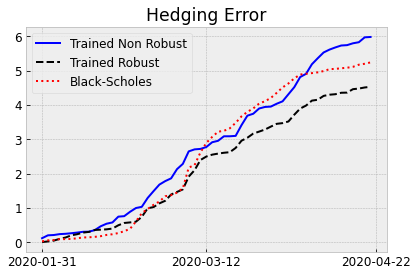

In [40]:
plt.title("Hedging Error")
plt.plot(np.cumsum(Rewards_2),color = "blue",label ="Trained Non Robust")
plt.plot(np.cumsum(Rewards_robust_2),color = "black",label ="Trained Robust",linestyle = "dashed")
plt.plot(np.cumsum(Rewards_BS_2),color = "red",label ="Black-Scholes",linestyle = "dotted")
xtick_numbers_test1 = [0,int(len(Rewards_2)/2),len(Rewards_2)] #,len(S_train)+len(S_test1),len(S_train)+len(S_test1)+len(S_test2)]
plt.xticks(xtick_numbers_test1, [S_test1["Date"].dt.date.iloc[xtick_numbers_test1[0]],
                                 S_test1["Date"].dt.date.iloc[xtick_numbers_test1[1]],
                                 S_test1["Date"].dt.date.iloc[xtick_numbers_test1[2]-1]] )#,S_test1["Date"].dt.date.iloc[0],S_test2["Date"].dt.date.iloc[0]])
plt.legend()
plt.tight_layout()
plt.savefig('test1.pdf', format='pdf')
plt.show()


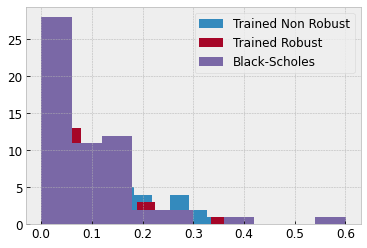

In [41]:
plt.hist(Rewards_2,label ="Trained Non Robust")
plt.hist(Rewards_robust_2,label ="Trained Robust")
plt.hist(Rewards_BS_2,label ="Black-Scholes")
plt.legend()
plt.show()

# 3) Evaluation in Testing Period 2


In [42]:
df_merged_3, Rewards_3, Rewards_robust_3, Rewards_BS_3,  Rewards_quadratic_3, Rewards_robust_quadratic_3, Rewards_BS_quadratic_3 = evaluate_nn(Returns_test2_tf,a_tilde,a_tilde_robust)


df_merged_3.round(4).describe()

,"Non-Robust, Prospect Utility","Robust, Prospect Utility","Black-Scholes, Prospect Utility","Non-Robust, Quadratic Error","Robust, Quadratic Error","Black-Scholes, Quadratic Error"
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,0.051024,0.039310,0.020795,0.000514,0.000744,0.000059
std,0.048292,0.025909,0.021392,0.000987,0.000890,0.000160
min,0.001400,0.001700,0.000000,0.000000,0.000000,0.000000
25%,0.018350,0.019050,0.006700,0.000000,0.000100,0.000000
50%,0.036400,0.037400,0.013000,0.000100,0.000500,0.000000
75%,0.069700,0.055700,0.024550,0.000550,0.000950,0.000000
max,0.248600,0.119700,0.100300,0.006700,0.004200,0.000900


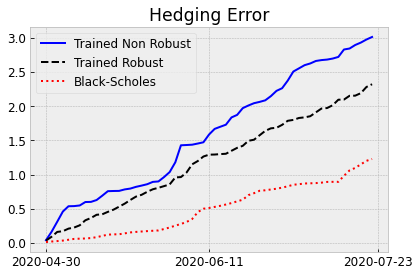

In [43]:
plt.title("Hedging Error")
plt.plot(np.cumsum(Rewards_3),color = "blue",label ="Trained Non Robust")
plt.plot(np.cumsum(Rewards_robust_3),color = "black",label ="Trained Robust",linestyle = "dashed")
plt.plot(np.cumsum(Rewards_BS_3),color = "red",label ="Black-Scholes",linestyle = "dotted")
xtick_numbers_test2 = [0,int(len(Rewards_3)/2),len(Rewards_3)] #,len(S_train)+len(S_test1),len(S_train)+len(S_test1)+len(S_test2)]
plt.xticks(xtick_numbers_test2, [S_test2["Date"].dt.date.iloc[xtick_numbers_test2[0]],
                                 S_test2["Date"].dt.date.iloc[xtick_numbers_test2[1]],
                                 S_test2["Date"].dt.date.iloc[xtick_numbers_test2[2]-1]] )#,S_test1["Date"].dt.date.iloc[0],S_test2["Date"].dt.date.iloc[0]])
plt.legend()
plt.tight_layout()
plt.savefig('test2.pdf', format='pdf')
plt.show()

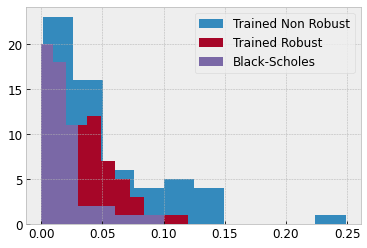

In [44]:
plt.hist(Rewards_3,label ="Trained Non Robust")
plt.hist(Rewards_robust_3,label ="Trained Robust")
plt.hist(Rewards_BS_3,label ="Black-Scholes")
plt.legend()

plt.show()